# Al_Querier

This notebook outlines the active learning query process, with some comments. This notebook is hardcoded to query on 1000 spectra, but this can be changed in the last cell (see comments). This notebook is set up to have read and run the entire run of the guadalupe csv (which is not saved in this repository).

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import unique, Table

from numpy.lib.recfunctions import structured_to_unstructured
import fitsio

In [2]:
tbl_data = Table.read("../qnet_ensemble_guadalupe.csv")

In [3]:
tbl_data

TARGETID,TILEID,EXPID,C_NOT,C_QSO_LZ,C_QSO_HZ,BMU
int64,int64,int64,float64,float64,float64,int64
39627758518669118,1000,89031,0.135,0.865,0.0,1086
39627764562658182,1000,89031,1.0,0.0,0.0,180
39627764562660466,1000,89031,0.015,0.0,0.985,919
39627764566852122,1000,89031,1.0,0.0,0.0,1052
39627764566854344,1000,89031,1.0,0.0,0.0,1012
616088516866081489,1000,89031,1.0,0.0,0.0,1325
39627764562662455,1000,89031,1.0,0.0,0.0,963
39627764562661595,1000,89031,1.0,0.0,0.0,1021
39627758518669735,1000,89031,1.0,0.0,0.0,976


# Ensemble Checking

The next cell checks how many networks were used in the ensemble and the following cell lists all the tiles that have been run.

In [4]:
cs = sorted(tbl_data["C_NOT"])
cs = np.diff(cs)
cs_nonzero = cs != 0
n_ens = int(1 / np.min(cs[cs_nonzero]))
n_ens

200

In [5]:
tile_ids = sorted(np.unique(tbl_data["TILEID"]))
tile_ids, len(tile_ids)

([1000,
  1001,
  1007,
  1010,
  1030,
  1078,
  1080,
  1081,
  1082,
  1083,
  1084,
  1085,
  1086,
  1087,
  1088,
  1089,
  1090,
  1091,
  1092,
  1093,
  1094,
  1095,
  1096,
  1097,
  1098,
  1099,
  1100,
  1101,
  1102,
  1103,
  1104,
  1105,
  1106,
  1107,
  1108,
  1109,
  1110,
  1111,
  1114,
  1116,
  1117,
  1120,
  1124,
  1125,
  1126,
  1128,
  1129,
  1130,
  1134,
  1191,
  1192,
  1193,
  1195,
  1196,
  1197,
  1198,
  1199,
  1200,
  1205,
  1206,
  1207,
  1208,
  1209,
  1210,
  1211,
  1212,
  1213,
  1218,
  1219,
  1220,
  1221,
  1222,
  1223,
  1224,
  1225,
  1226,
  1230,
  1232,
  1233,
  1234,
  1235,
  1236,
  1237,
  1238,
  1239,
  1240,
  1241,
  1242,
  1243,
  1244,
  1245,
  1246,
  1247,
  1248,
  1249,
  1250,
  1251,
  1252,
  1253,
  1254,
  1256,
  1257,
  1258,
  1295,
  1299,
  1308,
  1310,
  1311,
  1384,
  1385,
  1386,
  1387,
  1388,
  1389,
  1390,
  1391,
  1392,
  1393,
  1394,
  1395,
  1396,
  1397,
  1398,
  1399,
  1400,


# Entropy

We can query with a variety of different metrics (for example: least confidence and smallest margin) but for the third query strategy (entropy) we need to actually calculate the entropy. We calculate the entropy, then add it as an additional column. Since we're querying for the spectra with the highest entropy we sort the table by the entropy column.

In [6]:
def calc_entropy(confidence):
    H = confidence * np.log(confidence)
    H = np.where(confidence == 0, 0, H)
    return -np.sum(H, axis=1)


In [7]:
confs = structured_to_unstructured(np.asarray(tbl_data["C_NOT", "C_QSO_LZ", "C_QSO_HZ"]))
entropy = calc_entropy(confs)

/tmp/ipykernel_30236/885452469.py:2: RuntimeWarning: divide by zero encountered in log
  H = confidence * np.log(confidence)
/tmp/ipykernel_30236/885452469.py:2: RuntimeWarning: invalid value encountered in multiply
  H = confidence * np.log(confidence)


In [8]:
tbl_data.add_column(entropy, name="ENTROPY")

In [9]:
tbl_data.sort("ENTROPY", reverse=True)

tbl_data

TARGETID,TILEID,EXPID,C_NOT,C_QSO_LZ,C_QSO_HZ,BMU,ENTROPY
int64,int64,int64,float64,float64,float64,int64,float64
39633054049765137,1791,88873,0.34,0.33,0.33,740,1.0985126170507196
39627703741055635,1083,91171,0.335,0.34,0.325,1185,1.0984368565761047
39627777833441573,1835,93282,0.35,0.33,0.32,878,1.0979153802869457
39627753825244495,1841,94986,0.36,0.32,0.32,971,1.097032390352067
39627709650829350,1120,91063,0.345,0.305,0.35,1113,1.0967607591718467
39632971321314289,2162,88532,0.355,0.305,0.34,879,1.0966168618656336
39633100581374253,1734,89271,0.35,0.3,0.35,374,1.0960673284468554
39627969836092800,2986,97429,0.36,0.345,0.295,418,1.095077273664015
39627946830336921,1848,94622,0.295,0.375,0.33,417,1.0937997131510127


The red line in this histogram of entropy values represents the cutoff above which we have 1000 spectra. 

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1 ]
0.7217292244889169


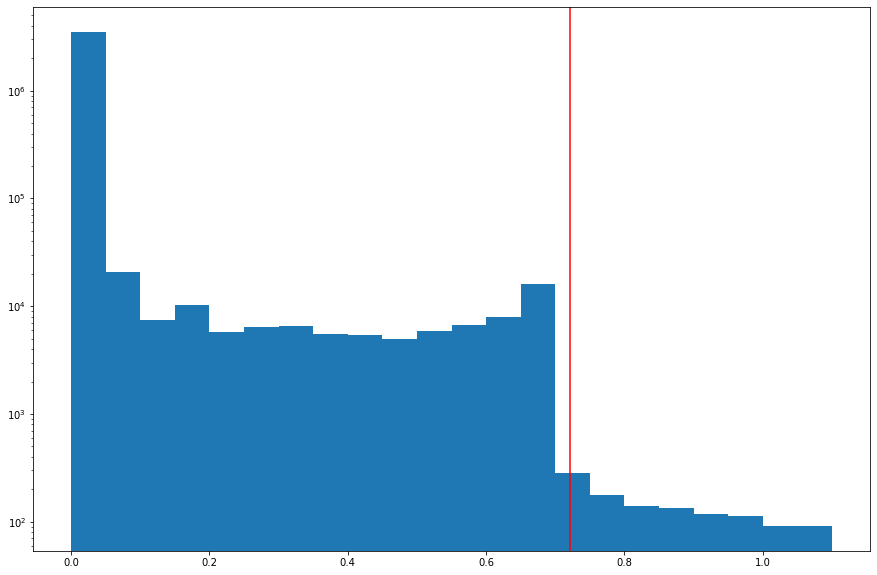

In [10]:
bins = np.linspace(0, 1.1, 23)
print(bins)
fig, ax = plt.subplots(figsize=(15, 10))
n, bins, _ = plt.hist(entropy, bins=bins)
plt.yscale("log")

cutoff = sorted(entropy)[-1000]
plt.axvline(x = cutoff, c="r")
print(cutoff)

# Outlier Removal

We include the BMU for each spectra in the BMU column. This BMU is for the SOM we trained and use for outlier detection. In this cell we remove any row where the spectra has been put into a cell that does not have a minimum number of spectra, in this case, the 15th percentile of all cell occupation numbers. 

In [11]:
percentile_cut = 15
bmu_counts = np.bincount(tbl_data["BMU"], minlength=np.max(tbl_data["BMU"]))
good_bmu = bmu_counts > np.percentile(bmu_counts, percentile_cut)
good_idcs = good_bmu[tbl_data["BMU"]]

tbl_reduced = tbl_data[good_idcs]
tbl_reduced

TARGETID,TILEID,EXPID,C_NOT,C_QSO_LZ,C_QSO_HZ,BMU,ENTROPY
int64,int64,int64,float64,float64,float64,int64,float64
39633054049765137,1791,88873,0.34,0.33,0.33,740,1.0985126170507196
39627703741055635,1083,91171,0.335,0.34,0.325,1185,1.0984368565761047
39627777833441573,1835,93282,0.35,0.33,0.32,878,1.0979153802869457
39627753825244495,1841,94986,0.36,0.32,0.32,971,1.097032390352067
39627709650829350,1120,91063,0.345,0.305,0.35,1113,1.0967607591718467
39632971321314289,2162,88532,0.355,0.305,0.34,879,1.0966168618656336
39633100581374253,1734,89271,0.35,0.3,0.35,374,1.0960673284468554
39627969836092800,2986,97429,0.36,0.345,0.295,418,1.095077273664015
39627946830336921,1848,94622,0.295,0.375,0.33,417,1.0937997131510127


In [12]:
tbl_no_dupe = unique(tbl_reduced, keys="TARGETID")
tbl_no_dupe.sort("ENTROPY", reverse=True)
tbl_no_dupe

TARGETID,TILEID,EXPID,C_NOT,C_QSO_LZ,C_QSO_HZ,BMU,ENTROPY
int64,int64,int64,float64,float64,float64,int64,float64
39633054049765137,1791,88873,0.34,0.33,0.33,740,1.0985126170507196
39627703741055635,1083,91171,0.335,0.34,0.325,1185,1.0984368565761047
39627777833441573,1835,93282,0.35,0.33,0.32,878,1.0979153802869457
39627753825244495,1841,94986,0.36,0.32,0.32,971,1.097032390352067
39627709650829350,1120,91063,0.345,0.305,0.35,1113,1.0967607591718467
39632971321314289,2162,88532,0.355,0.305,0.34,879,1.0966168618656336
39633100581374253,1734,89271,0.35,0.3,0.35,374,1.0960673284468554
39627969836092800,2986,97429,0.36,0.345,0.295,418,1.095077273664015
39627946830336921,1848,94622,0.295,0.375,0.33,417,1.0937997131510127


This last removal cell removes duplicate TARGETIDS. Since we run all individual exposures of the spectra, there can (and are) duplicate TARGETIDS. Since we will use the coadded spectra for visual inspection, we can increase the number of TARGETIDS we query on by removing TARGETIDS that get duplicated. We keep the highest entropy value of each TARGETID, which means that, for example, if there were two exposures with the same TARGETID with different entropy values above the cutoff, we remove one and can thus query an addition TARGETID. 

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075 1.1  ]
0.711973911586556


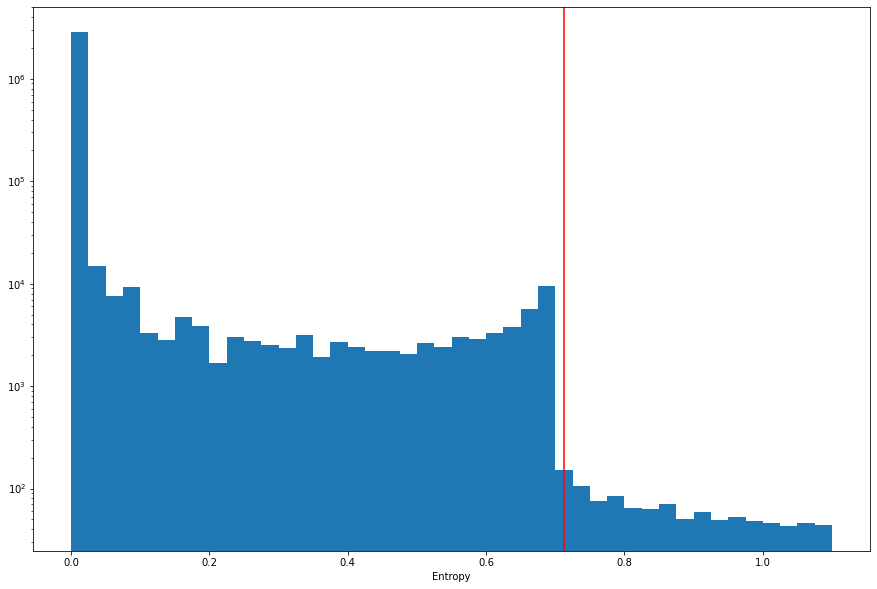

In [13]:
entropy_reduced = tbl_no_dupe["ENTROPY"][:]
bins = np.linspace(0, 1.1, 23*2 - 1)
print(bins)
fig, ax = plt.subplots(figsize=(15, 10))
n, bins, _ = plt.hist(entropy_reduced, bins=bins)
plt.yscale("log")

cutoff = sorted(entropy_reduced)[-1000]
plt.axvline(x = cutoff, c="r")

plt.xlabel("Entropy")
print(cutoff)
plt.savefig("entropy_dist.jpg", dpi=256, bbox_inches="tight")

In [14]:
# Saves the TARGETIDS to query on.
target_id_file = "targetid_selection.txt"
with open(target_id_file, "w") as f:
    # Change this 1000 if you want to change the number of spectra queried.
    for x in tbl_no_dupe["TARGETID"][:1000]:
        f.write(f"{x}\n")